# Notebook 3 : Model 

In [ ]:
#%pip install scikeras[tensorflow]


In [ ]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
from datetime import datetime, timedelta
import tensorflow as tf
from tensorflow import keras
import sklearn as sk
from keras import regularizers
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler
import matplotlib as mpl
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense,Dropout
from tensorflow.keras.models import Model
from keras.regularizers import l2
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"


#### Method I

In [3]:
balanced_dataset=pd.read_csv('dataset_final.csv',header=0)
balanced_dataset=balanced_dataset.iloc[:,1:]
balanced_dataset=balanced_dataset.drop_duplicates(subset=balanced_dataset.columns, keep="first")

In [159]:
balanced_dataset.duplicated().any() 

False

In [5]:
print(balanced_dataset['FIRE_EVENT'].value_counts()[1])
print(balanced_dataset['FIRE_EVENT'].value_counts()[0])

20199
319501


In [144]:
balanced_dataset.head(3)

,FOREST_FIRE_LATITUDE,FOREST_FIRE_LONGITUDE,SIZE_HA,YEAR,MONTH,DAY,ClimateID,WEATHER_STATION_LATITUDE,WEATHER_STATION_LONGITUDE,Euclideandist,LONGITUDE,LATITUDE,MEAN_TEMPERATURE,LOCAL_DAY,MAX_REL_HUMIDITY,COOLING_DEGREE_DAYS,MIN_REL_HUMIDITY,TOTAL_PRECIPITATION,MAX_TEMPERATURE,SNOW_ON_GROUND,LOCAL_MONTH,TOTAL_SNOW,HEATING_DEGREE_DAYS,LOCAL_YEAR,DIRECTION_MAX_GUST,MIN_TEMPERATURE,SPEED_MAX_GUST,TOTAL_RAIN,FIRE_EVENT,LOCAL_OUT_DAY,LOCAL_OUT_MONTH,LOCAL_OUT_YEAR
0,53.182254,-105.844939,0.01,1989,7,8,4056240.0,53.216667,-105.666667,0.181563,-105.666666,53.216666,19.0,8,100,1.0,91,1.2,24.1,0,7,0.0,0.0,1989,11,13.9,50,1.2,1,8,7,1989
1,53.213500,-105.885400,0.01,1989,7,8,4056240.0,53.216667,-105.666667,0.218756,-105.666666,53.216666,19.0,8,100,1.0,91,1.2,24.1,0,7,0.0,0.0,1989,11,13.9,50,1.2,1,8,7,1989
2,53.005200,-106.010400,0.50,1987,6,20,4054795.0,53.016667,-106.016667,0.013068,-106.016666,53.016666,21.0,20,82,3.0,48,2.6,29.0,8,6,0.0,0.0,1987,29,13.0,56,2.6,1,20,6,1987


In [ ]:
X = balanced_dataset.drop(['FIRE_EVENT','FOREST_FIRE_LATITUDE','FOREST_FIRE_LONGITUDE'], axis=1)
y = balanced_dataset[['FIRE_EVENT','FOREST_FIRE_LATITUDE','FOREST_FIRE_LONGITUDE']]
X_train, X_test, y_train, y_test = train_test_split( test_size=0.2,stratify=y,random_state=42)
test_dataset=X_test.copy()
Y1_train = np.array(X_train["FOREST_FIRE_LATITUDE"])
Y2_train = np.array(X_train["FOREST_FIRE_LONGITUDE"])

In [80]:
scale = StandardScaler()
X_train = balanced_dataset.loc[:,balanced_dataset.columns!="FIRE_EVENT"]
X_train = scale.fit_transform(X_train)
# Y is just the 'Fire Event' column
y = balanced_dataset['FIRE_EVENT'].values
X_train, X_test, y_train, y_test = train_test_split(X_train, y, test_size=0.2)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [81]:
print('Training labels shape:', X_train.shape)
print('Test labels shape:', X_test.shape)

Training labels shape: (269978, 31)
Test labels shape: (67495, 31)


In [82]:
model = Sequential()
model.add(Dense(12, input_shape=(31,), activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(6, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [83]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/100
132/132 [==============================] - 1s 2ms/step - loss: 0.5231 - accuracy: 0.9518
Epoch 2/100
132/132 [==============================] - 0s 2ms/step - loss: 0.0198 - accuracy: 0.9996
Epoch 3/100
132/132 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 1.0000
Epoch 4/100
132/132 [==============================] - 0s 2ms/step - loss: 4.1083e-04 - accuracy: 1.0000
Epoch 5/100
132/132 [==============================] - 0s 2ms/step - loss: 2.0493e-04 - accuracy: 1.0000
Epoch 6/100
132/132 [==============================] - 0s 2ms/step - loss: 

In [84]:
_, accuracy = model.evaluate(X_train, y_train)
print('Accuracy: %.2f' % (accuracy*100))
predictions = model.predict(X_test)
rounded = [round(x[0]) for x in predictions]
predictions = (model.predict(X_test) > 0.5).astype(int)

8437/8437 [==============================] - 8s 974us/step - loss: 3.1351e-09 - accuracy: 1.0000
Accuracy: 100.00
2110/2110 [==============================] - 2s 864us/step


<Axes: >

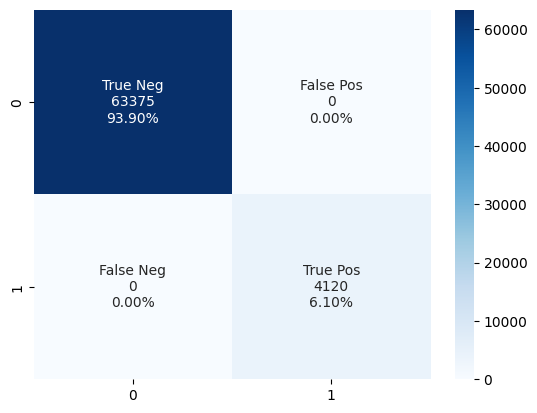

In [86]:
#for i in range(3):
	#print('%s => %d (expected %d)' % (X_test[i].tolist(), predictions[i], y[i]))
predictions = (model.predict(X_test) > 0.5).astype(int)
cf_matrix=confusion_matrix(y_test, predictions)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

### Method II

In [3]:
balanced_dataset=pd.read_csv('dataset_final.csv',header=0)
balanced_dataset=balanced_dataset.iloc[:,1:]
balanced_dataset=balanced_dataset.drop_duplicates(subset=balanced_dataset.columns, keep="first")

In [4]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits = 4)
balanced_dataset.set_index('YEAR', inplace=True)
balanced_dataset.sort_index(inplace=True)
X = balanced_dataset.drop(['FIRE_EVENT','LONGITUDE','LATITUDE','LOCAL_MONTH','LOCAL_DAY'], axis=1)
y = balanced_dataset['FIRE_EVENT']

In [16]:
for train_index, test_index in tss.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index].values, y.iloc[test_index].values

#def plotsplit(x):
    #if type(x) == str: 
        #x = x.strip('$').replace(',', '')
        #return float(x)
#function to convert price from string to floats
#y_train=y_train.apply(plotsplit)
#y_train.groupby('YEAR').mean().plot(label="Train Set")
#y_test=y_test.apply(plotsplit)
#y_test.groupby('YEAR').mean().plot(label="Test Set")
#plt.legend(loc="upper right")


SMOTE

FIRE_EVENT
0    180596
1     20199
Name: count, dtype: int64

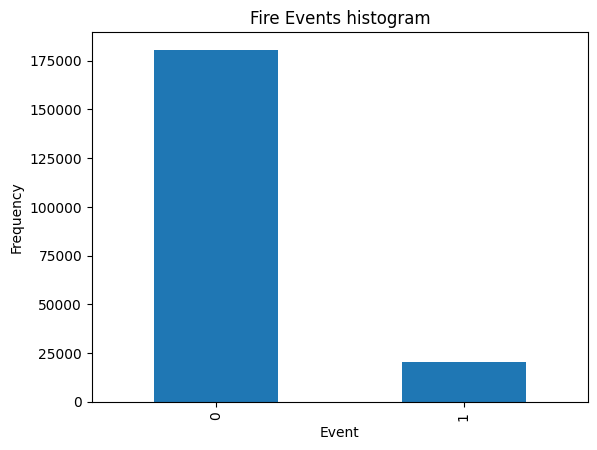

In [6]:
pd.value_counts(y).plot.bar()
plt.title('Fire Events histogram')
plt.xlabel('Event')
plt.ylabel('Frequency')
y.value_counts()

In [17]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

Before OverSampling, counts of label '1': 16165
Before OverSampling, counts of label '0': 144471 

After OverSampling, the shape of train_X: (288942, 26)
After OverSampling, the shape of train_y: (288942,) 

After OverSampling, counts of label '1': 144471
After OverSampling, counts of label '0': 144471


In [8]:
output=X_test.copy()
#output.reset_index(inplace=True)
output['Actual']=y_test
input_num=len(X_train.columns)

In [30]:
import collections
print(collections.Counter(y_train))
print(collections.Counter(y_test))


Counter({0: 135452, 1: 15145})
Counter({0: 45144, 1: 5054})


In [18]:
input_num=len(X_train.columns)
sc = MinMaxScaler(feature_range=(0,1))
X_train_scaled = sc.fit_transform(X_train_res)
X_test_scaled = sc.transform(X_test)

In [65]:
#Tried with LSTM Model
early_stopping = EarlyStopping(monitor="acc",restore_best_weights=True)
opt = Adam(lr=0.0001)
def create_model_lstm():
    model = Sequential()
    model.add(LSTM(100,input_shape = (input_num,1),return_sequences=True))
    model.add(Dense(6, kernel_regularizer=regularizers.l1_l2(0.3)))
    model.add(LSTM(50, dropout=0.7, recurrent_dropout=0.7))
    model.add(Dense(4, kernel_regularizer=regularizers.l1_l2(0.3)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

model=create_model_lstm()

2023-12-12 20:21:21.460043: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-12 20:21:21.461930: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-12 20:21:21.463148: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [19]:
early_stopping = EarlyStopping(monitor="acc",restore_best_weights=True)
kfold = KFold(n_splits=5, shuffle=True)
acc_per_fold = []
loss_per_fold = []
# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(X_train_scaled, y_train_res):
    model = Sequential()
    model.add(Dense(12, input_shape=(input_num,), activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(8, activation='relu'))
    model.add(Dropout(0.6))
    model.add(Dense(6, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(4, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
    history = model.fit(X_train_scaled[train], y_train_res[train],
            batch_size=2048,
            epochs=10)
    # Generate generalization metrics
    scores = model.evaluate(X_train_scaled[test], y_train_res[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no = fold_no + 1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]}')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Loss: {np.mean(loss_per_fold)}')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print('------------------------------------------------------------------------')

Epoch 1/10
113/113 [==============================] - 1s 3ms/step - loss: 0.5972 - acc: 0.6614
Epoch 2/10
113/113 [==============================] - 0s 3ms/step - loss: 0.2846 - acc: 0.9019
Epoch 3/10
113/113 [==============================] - 0s 3ms/step - loss: 0.1569 - acc: 0.9452
Epoch 4/10
113/113 [==============================] - 0s 3ms/step - loss: 0.1205 - acc: 0.9516
Epoch 5/10
113/113 [==============================] - 0s 3ms/step - loss: 0.1064 - acc: 0.9548
Epoch 6/10
113/113 [==============================] - 0s 3ms/step - loss: 0.1009 - acc: 0.9569

In [ ]:
predictions=model.predict(X_test_scaled)

In [41]:
#predictions=model.predict(X_test)
#classes=[1 if i>0.5 else 0 for i in predictions]
classes=[0 if i==0 else 0 if i>0 and i<=0.98 else 1 if i>0.98 and i<=1 else 1 for i in a]
#print(classes)
print(classification_report(y_test,classes))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     36125
           1       1.00      0.93      0.96      4034

    accuracy                           0.99     40159
   macro avg       1.00      0.96      0.98     40159
weighted avg       0.99      0.99      0.99     40159



<Axes: >

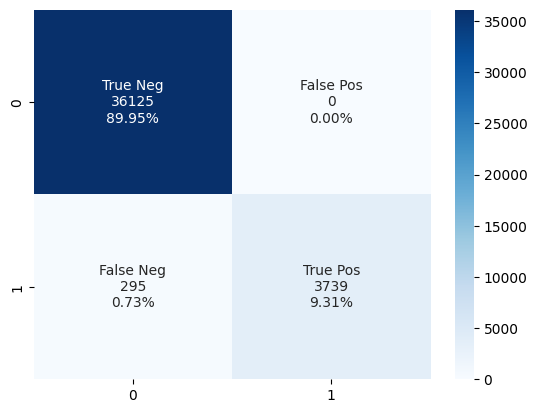

In [42]:
cf_matrix=confusion_matrix(y_test, classes)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

###### Data Stored to container

In [46]:
output=X_test.copy()
output.reset_index(inplace=True)
output['Actual']=y_test
output['Predicted']=classes
output['DATE'] = pd.to_datetime(output[['YEAR', 'MONTH','DAY']].assign(DAY=1))
#output=output.drop(columns=['level_0','index'],axis=1)
output.to_csv('updated_output.csv', encoding='utf-8', index=False)